In [246]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import os
import random
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import xgboost as xgb
from scipy.spatial.distance import squareform, pdist
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import DistanceMetric
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import random

# 전처리

## 데이터 전처리

### Round1의 weather 예측값 전처리(Expert model의 input)

In [247]:
weather_real = pd.read_csv("./OIBC2023_data/weather_actual.csv")
weather_real = weather_real.drop(['time'],axis=1)
weather_real

,cloud,temp,humidity,ground_press,wind_speed,wind_dir,rain,snow,dew_point,vis,uv_idx,azimuth,elevation
0,5.871524,23.030000,91.128476,1009.000000,2.394132,152.173538,0.0,0.0,20.193333,19.193333,0.0,6.704280,-31.529640
1,5.000000,20.046829,92.000000,1009.000000,2.490000,133.000000,0.0,0.0,20.010169,16.100000,0.0,22.196370,-28.440428
2,31.668514,20.275571,92.000000,1008.012749,2.340765,139.974501,0.0,0.0,20.304918,16.257377,0.0,35.919394,-22.437437
3,100.000000,20.380388,93.000000,1008.000000,2.770000,142.000000,0.0,0.0,20.403077,19.004615,0.0,47.557714,-14.221450
4,100.000000,22.030000,93.000000,1008.000000,2.557647,133.882353,0.0,0.0,20.495385,10.143077,0.0,57.378183,-4.444699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.000000,18.807459,70.000000,1014.000000,6.320000,307.000000,0.0,0.0,13.204762,16.100000,0.0,277.464745,-25.379191
11612,0.000000,17.918518,67.888518,1015.000000,5.553144,306.554073,0.0,0.0,13.300000,16.100000,0.0,287.678638,-37.409688
11613,0.000000,17.030000,67.000000,1015.000000,5.100000,303.000000,0.0,0.0,13.055738,20.349180,0.0,301.007172,-48.655175
11614,0.000000,18.730542,67.000000,1015.000000,5.190000,297.000000,0.0,0.0,12.183333,9.590000,0.0,320.433966,-58.056463


In [248]:
# real_weather & pred_weather 오차
weather = pd.read_csv("./OIBC2023_data/weather_forecast.csv")
weather = weather[weather['round']==1].drop(['round','time'],axis=1)
# pca = PCA(n_components = 13)
# weather = pca.fit_transform(weather)
# ss = StandardScaler()
ss = MinMaxScaler()
ss_weather = pd.DataFrame(ss.fit_transform(weather))
ss_weather

# ss_weather = pd.concat([ss_weather, (weather-weather_real)/(weather_real.min()-weather_real.max())],axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.06,0.721352,0.898551,0.431373,0.126821,0.450000,0.0,0.0,0.794519,0.829786,0.0,0.003232,0.295698
1,0.07,0.717230,0.927536,0.431373,0.133248,0.441667,0.0,0.0,0.794519,0.829786,0.0,0.048040,0.315648
2,0.17,0.720253,0.942029,0.411765,0.122965,0.447222,0.0,0.0,0.794519,0.829786,0.0,0.087732,0.354414
3,1.00,0.725749,0.942029,0.411765,0.117395,0.436111,0.0,0.0,0.780822,0.829786,0.0,0.121393,0.407472
4,1.00,0.729871,0.927536,0.411765,0.115253,0.433333,0.0,0.0,0.794519,0.829786,0.0,0.149797,0.470608
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11611,0.00,0.679308,0.594203,0.549020,0.233076,0.902778,0.0,0.0,0.657534,0.829786,0.0,0.786359,0.335416
11612,0.00,0.682056,0.608696,0.549020,0.227506,0.869444,0.0,0.0,0.657534,0.829786,0.0,0.815901,0.257725
11613,0.00,0.683155,0.608696,0.549020,0.245073,0.850000,0.0,0.0,0.657534,0.829786,0.0,0.854450,0.185104
11614,0.00,0.684804,0.565217,0.549020,0.251071,0.838889,0.0,0.0,0.643835,0.829786,0.0,0.910639,0.124392


### Round1의 Expert model 결과값 전처리

,model0,model1,model2,model3,model4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
11611,0.0,0.0,0.0,0.0,0.0
11612,0.0,0.0,0.0,0.0,0.0
11613,0.0,0.0,0.0,0.0,0.0
11614,0.0,0.0,0.0,0.0,0.0


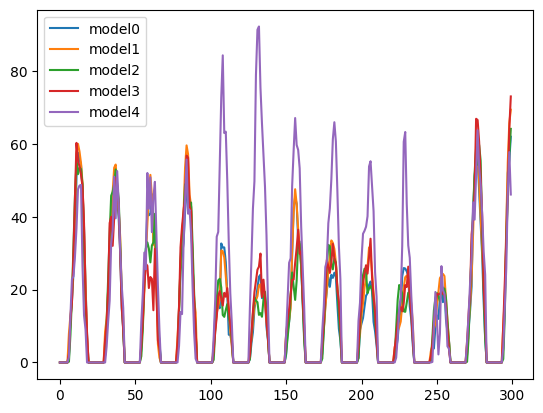

In [249]:
pred = pd.read_csv("./OIBC2023_data/pred.csv")
pred = pred[pred['round']==1].drop(['round', 'time'],axis=1)
for i in range(5):
    exec(f"pred{i} = pred[pred['model_id']==i].drop(['model_id'], axis=1).reset_index(drop=True)")
    exec(f"pred{i}.columns = ['model{i}']")
gen_pred = pd.concat([eval(f'pred{i}') for i in range(5)], axis=1)
gen_pred.iloc[:300].plot()
gen_pred

### 실제 gen 값 전처리

In [250]:
gen = pd.read_csv("./OIBC2023_data/gens.csv").drop(['time'], axis=1)
gen

,amount
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
11611,0.0
11612,0.0
11613,0.0
11614,0.0


## 학습/검증 데이터 전처리

In [251]:
ss_weather_dataset = torch.tensor(np.array(ss_weather)).type(torch.float32)
gen_pred_dataset = torch.tensor(np.array(gen_pred)).type(torch.float32)
gen_dataset = torch.tensor(np.array(gen)).type(torch.float32)
ss_weather_dataset.shape, gen_pred_dataset.shape, gen_dataset.shape

(torch.Size([11616, 13]), torch.Size([11616, 5]), torch.Size([11616, 1]))

In [252]:
# weather_pred 13 & gen_pred 5 & gen 1 
total_dataset = torch.cat([ss_weather_dataset, gen_pred_dataset, gen_dataset], dim=1)
total_dataset.shape     

torch.Size([11616, 19])

In [253]:
# 시간 고려 -> Train : Val = 앞 90% : 뒤 10%
train_dataset = total_dataset[:-len(total_dataset)//10]
val_dataset = total_dataset[-len(total_dataset)//10:]
train_dataset.shape, val_dataset.shape

(torch.Size([10454, 19]), torch.Size([1162, 19]))

In [254]:
# batch dataset(input_X : pred_weather, infer_X : pred_gen, true_Y : gen)
def make_batch_dataset(train_dataset, batch_size = 1024):
    batch_dataset = train_dataset[random.sample(range(len(train_dataset)), k=batch_size)]
    batch_input_X = batch_dataset[:,:18]
    batch_infer_X = batch_dataset[:,13:18]
    batch_true_Y = batch_dataset[:,[18]]
    return batch_input_X, batch_infer_X, batch_true_Y

In [255]:
def make_validation_dataset(val_dataset):
    batch_dataset = val_dataset
    batch_input_X = batch_dataset[:,:18]
    batch_infer_X = batch_dataset[:,13:18]
    batch_true_Y = batch_dataset[:,[18]]
    return batch_input_X, batch_infer_X, batch_true_Y

# Loss Function

In [256]:
############################# TEST 용도 ###############################
batch_size = 1024
batch_dataset = train_dataset[random.sample(range(len(train_dataset)), k=batch_size)]
batch_input_X = batch_dataset[:,:18]
batch_infer_X = batch_dataset[:,13:18]
batch_true_Y = batch_dataset[:,[18]]
batch_pred_Y = nn.ReLU()((batch_true_Y-3)*0.93)
###################################################################

In [257]:
def train_loss(batch_true_Y, batch_pred_Y):
    # Utilization preprocess
    batch_true_Y[batch_true_Y < 9.9] = 0

    error_abs = torch.abs(batch_pred_Y - batch_true_Y)
    # error_type1 = torch.square(error_abs[((error_abs/99*100)>6) & ((error_abs/99*100)<=8) & (batch_true_Y > 0)])
    # error_type2 = torch.square(error_abs[((error_abs/99*100)>8) & (batch_true_Y > 0)])
    # error_type1 = torch.abs(error_abs[((error_abs/99*100)>6) & ((error_abs/99*100)<=8) & (batch_true_Y > 0)])
    # error_type2 = torch.abs(error_abs[((error_abs/99*100)>8) & (batch_true_Y > 0)])
    error_type1 = torch.sqrt(error_abs[((error_abs/99*100)>6) & ((error_abs/99*100)<=8) & (batch_true_Y > 0)])
    error_type2 = torch.sqrt(error_abs[((error_abs/99*100)>8) & (batch_true_Y > 0)])
    cost_type1 = batch_true_Y[((error_abs/99*100)>6) & ((error_abs/99*100)<=8) & (batch_true_Y > 0)]
    cost_type2 = batch_true_Y[((error_abs/99*100)>8) & (batch_true_Y > 0)] * 4
    error_type1_num = len(cost_type1)
    error_type2_num = len(cost_type2)
    batch_size = len(batch_true_Y[batch_true_Y > 0])

    # loss
    if (error_type1_num != 0) and (error_type2_num != 0):
        loss = (torch.sum(error_type1 * cost_type1) + torch.sum(error_type2 * cost_type2)) / (batch_size)
    elif (error_type1_num != 0):
        loss = torch.sum(error_type1 * cost_type1) / (batch_size)
    elif (error_type2_num != 0):
        loss = torch.sum(error_type2 * cost_type2) / (batch_size)
    else:
        loss = torch.tensor(0.)

    return loss

In [258]:
train_loss(batch_true_Y, batch_pred_Y)

tensor(196.9435)

In [259]:
def validation(val_batch_true_Y, val_batch_pred_Y):
    val_true_Y = np.array(val_batch_true_Y.detach())
    val_pred_Y = np.array(val_batch_pred_Y.detach())

    val_true_Y[val_true_Y < 9.9] = 0

    error_abs = np.abs(val_pred_Y - val_true_Y)
    cost_type1 = val_true_Y[((error_abs/99*100)>6) & ((error_abs/99*100)<=8) & (val_true_Y > 0)]
    cost_type2 = val_true_Y[((error_abs/99*100)>8) & (val_true_Y > 0)] * 4
    full_incentive = np.sum(val_true_Y[(val_true_Y > 0)] * 4)
    error_type1_num = len(cost_type1)
    error_type2_num = len(cost_type2)

    # loss
    if (error_type1_num != 0) and (error_type2_num != 0):
        loss = (np.sum(cost_type1) + np.sum(cost_type2))
    elif (error_type1_num != 0):
        loss = np.sum(cost_type1)
    elif (error_type2_num != 0):
        loss = np.sum(cost_type2)
    else:
        loss = 0.

    
    return loss, (1-loss/full_incentive)*100

In [260]:
validation(batch_true_Y, batch_pred_Y)

(27965.207, 61.45181357860565)

In [261]:
val_input_X, val_infer_X, val_true_Y = make_validation_dataset(val_dataset)
validation(val_infer_X.mean(1).reshape(-1,1), val_true_Y)

(44336.492, 39.7125780582428)

In [262]:
val_input_X, val_infer_X, val_true_Y = make_validation_dataset(val_dataset)
validation(val_infer_X[:,0].reshape(-1,1), val_true_Y)

(42327.094, 40.27444124221802)

In [263]:
val_input_X, val_infer_X, val_true_Y = make_validation_dataset(val_dataset)
validation(val_infer_X[:,1].reshape(-1,1), val_true_Y)

(41282.633, 45.11997699737549)

In [264]:
val_input_X, val_infer_X, val_true_Y = make_validation_dataset(val_dataset)
validation(val_infer_X[:,2].reshape(-1,1), val_true_Y)

(44529.098, 36.7592990398407)

In [265]:
val_input_X, val_infer_X, val_true_Y = make_validation_dataset(val_dataset)
validation(val_infer_X[:,3].reshape(-1,1), val_true_Y)

(39977.332, 44.111400842666626)

In [266]:
val_input_X, val_infer_X, val_true_Y = make_validation_dataset(val_dataset)
validation(val_infer_X[:,4].reshape(-1,1), val_true_Y)

(63651.79, 21.52915596961975)

### Loss 시각화

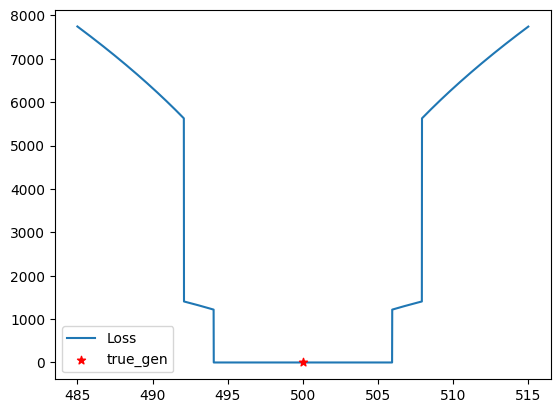

In [267]:
train_pred_list = [i/100 for i in range(48500, 51500, 1)]
true_y_list = torch.tensor([[500]])
result = []
for item in train_pred_list:
    result.append(train_loss(true_y_list, torch.tensor([[item]])).item())
plt.figure()
plt.plot(train_pred_list, result, label = 'Loss')
plt.scatter(x=[500], y=[0], c='r', zorder=2, label='true_gen', marker='*')
plt.legend()

# Model Architecture

In [268]:
# class Cluster_model(nn.Module):

#     def __init__(self):
#         super(Cluster_model, self).__init__()
#         self.fe = nn.Linear(18, 512)
#         self.hidden1 = nn.Linear(512,512)
#         self.hidden2 = nn.Linear(512,512)
#         self.latent = nn.Linear(512, 5)
#         self.softmax = nn.Softmax()
#         self.dropout = nn.Dropout(p=0.2)
#         # self.last = nn.Linear(1, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x, x1):
#         batch_size = len(x)
#         x = self.fe(x)
#         x = self.relu(x)
#         x = self.hidden1(x)
#         x = self.dropout(x)
#         x = self.relu(x)
#         x = self.hidden2(x)
#         x = self.dropout(x)
#         x = self.relu(x)
#         f = self.latent(x)
#         f = self.softmax(f)
#         x = torch.sum(f*x1, 1).reshape(batch_size, -1)
#         # x = self.last(x)
#         x = self.relu(x)
#         return x

In [272]:
class Cluster_model(nn.Module):

    def __init__(self):
        super(Cluster_model, self).__init__()
        self.fe = nn.Linear(18, 512)
        self.hidden1 = nn.Linear(512,512)
        self.hidden2 = nn.Linear(512,512)
        self.latent = nn.Linear(512, 5)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.5)
        # self.last = nn.Linear(1, 1)
        self.relu = nn.ReLU()

    def forward(self, x, x1):
        batch_size = len(x)
        x = self.fe(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.hidden1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.dropout(x)
        x = self.relu(x)
        f = self.latent(x)
        # f = self.softmax(f)
        x = torch.sum(f*x1, 1).reshape(batch_size, -1)
        # x = self.last(x)
        x = self.relu(x)
        return x

In [277]:
model = Cluster_model()
import copy
epoch = 1000000
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)
batch_size = 512
best_val_loss = 10000000000
best_accuracy = 0
best_model = None

val_input_X, val_infer_X, val_true_Y = make_validation_dataset(val_dataset)

for epoch_idx in range(epoch):
    model.train()
    optimizer.zero_grad()
    batch_input_X, batch_infer_X, batch_true_Y = make_batch_dataset(train_dataset, batch_size)
    batch_pred_Y = model(batch_input_X, batch_infer_X)
    loss = train_loss(batch_true_Y, batch_pred_Y)
    loss.backward()
    optimizer.step()

    
    model.eval()
    val_loss, val_accuracy = validation(val_true_Y, model(val_input_X, val_infer_X))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_accuracy = val_accuracy
        print(f"epoch : {epoch_idx+1}, efficiency: {best_accuracy:.2f}%, loss : {best_val_loss}")
        best_model = copy.deepcopy(model)
        torch.save(best_model, "best_model_round1.pt")

epoch : 1, efficiency: 18.33%, loss : 62480.0
epoch : 2, efficiency: 19.55%, loss : 61545.0
epoch : 3, efficiency: 21.34%, loss : 60172.0
epoch : 6, efficiency: 23.40%, loss : 58600.0
epoch : 12, efficiency: 25.16%, loss : 57249.0
epoch : 16, efficiency: 25.96%, loss : 56639.0
epoch : 20, efficiency: 26.63%, loss : 56128.0
epoch : 27, efficiency: 27.49%, loss : 55470.0
epoch : 28, efficiency: 28.48%, loss : 54715.0
epoch : 29, efficiency: 28.51%, loss : 54693.0
epoch : 35, efficiency: 28.74%, loss : 54510.5
epoch : 36, efficiency: 29.51%, loss : 53927.0
epoch : 44, efficiency: 29.98%, loss : 53564.0
epoch : 49, efficiency: 30.46%, loss : 53199.0
epoch : 54, efficiency: 32.05%, loss : 51981.5
epoch : 58, efficiency: 32.42%, loss : 51702.5
epoch : 66, efficiency: 34.35%, loss : 50222.0
epoch : 77, efficiency: 34.35%, loss : 50221.5
epoch : 94, efficiency: 34.44%, loss : 50153.5
epoch : 95, efficiency: 34.66%, loss : 49983.0
epoch : 102, efficiency: 34.82%, loss : 49859.5
epoch : 116, eff

KeyboardInterrupt: 

# Inference

In [278]:
test_weather = pd.read_csv("./OIBC2023_data/weather_fcst_10.csv")
test_weather = test_weather.drop(['time'],axis=1)
test_weather = test_weather
ss_test_weather = pd.DataFrame(ss.transform(test_weather), columns=test_weather.columns)


test_pred = pd.read_csv("./OIBC2023_data/gen_fcst_10.csv")
gen_test_pred = test_pred.drop(['time'],axis=1)


ss_test_weather_dataset = torch.tensor(np.array(ss_test_weather)).type(torch.float32)
gen_test_pred_dataset = torch.tensor(np.array(gen_test_pred)).type(torch.float32)

total_test_dataset = torch.cat([ss_test_weather_dataset, gen_test_pred_dataset], dim=1)

best_model.eval()
pred_y = best_model(total_test_dataset, gen_test_pred_dataset)

In [279]:
true_y_list = [[0.] for i in range(8)] + [[36.], [46.],[53.],[74.],[89.],[81.],[64.],[54.],[23.]] + [[0.] for i in range(7)]
true_y = torch.tensor(true_y_list).type(torch.float32)

In [280]:
validation(true_y, pred_y)

(989.0, 52.45192348957062)

In [ ]:
2080*(0.5072)

1054.9759999999999